<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Face_image_generation_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 686kB 9.6MB/s 


In [ ]:
pip install tensorflow_datasets==4.2.0

     |████████████████████████████████| 3.7MB 8.3MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
pip install tfds-nightly==4.2.0.dev202101190107

     |████████████████████████████████| 3.7MB 7.3MB/s 
  Found existing installation: tfds-nightly 4.3.0.dev202107080107
    Uninstalling tfds-nightly-4.3.0.dev202107080107:
      Successfully uninstalled tfds-nightly-4.3.0.dev202107080107


In [ ]:
import tensorflow_datasets as tfds
print(tfds.__version__)

4.2.0+nightly


In [ ]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow_addons.layers import InstanceNormalization

import tensorflow_datasets as tfds

In [ ]:
def log2(x):
    return int(np.log2(x))

In [ ]:
# we use different batch size for different resolution, so larger image size
# could fit into GPU memory. The keys is image resolution in log2
batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
# We adjust the train step accordingly
train_step_ratio = {k: batch_sizes[2] / v for k, v in batch_sizes.items()}


In [ ]:
train_step_ratio

{2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 2.0, 8: 4.0, 9: 8.0, 10: 16.0}

In [ ]:
ds_train = tfds.load("celeb_a", split="train")


def resize_image(res, sample):
    image = sample["image"]
    # only donwsampling, so use nearest neighbor that is faster to run
    image = tf.image.resize(
        image, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image

def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    dl = ds_train.map(partial(resize_image, res), num_parallel_calls=tf.data.AUTOTUNE)
    dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
    return dl


In [ ]:
ds_train = tfds.load("celeb_a", split="train")

In [ ]:
tfds.list_builders()


In [ ]:
def plot_images(images, log2_res, fname=""):
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

    grid_col = min(images.shape[0], int(32 // scale))
    grid_row = 1

    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * scale, grid_row * scale)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)

In [ ]:
def fade_in(alpha, a, b):
    return alpha * a + (1.0 - alpha) * b


def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)


def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)


def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1, 2, 3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)


class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(EqualizedConv, self).__init__(**kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel != 1

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.w = self.add_weight(
            shape=[self.kernel, self.kernel, self.in_channels, self.out_channels],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.out_channels,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.kernel * self.kernel * self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
        else:
            x = inputs
        output = (
            tf.nn.conv2d(x, self.scale * self.w, strides=1, padding="VALID") + self.b
        )
        return output


class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super(EqualizedDense, self).__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(
            mean=0.0, stddev=1.0 / self.learning_rate_multiplier
        )
        self.w = self.add_weight(
            shape=[self.in_channels, self.units],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
        return output * self.learning_rate_multiplier


class AddNoise(layers.Layer):
    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.b = self.add_weight(
            shape=[1, 1, 1, c], initializer=initializer, trainable=True, name="kernel"
        )

    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output


class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]

        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)

    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * x + yb

In [ ]:
def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, learning_rate_multiplier=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
    return keras.Model(z, w, name="mapping")


class Generator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # list of generator blocks at increasing resolution
        self.g_blocks = []
        # list of layers to convert g_block activation to RGB
        self.to_rgb = []
        # list of noise input of different resolutions into g_blocks
        self.noise_inputs = []
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024

        start_res = 2 ** start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name="generator_input")

        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_rgb = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    EqualizedConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_rgb.append(to_rgb)
            is_base = i == self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i - 1])
            else:
                input_shape = (2 ** (i - 1), 2 ** (i - 1), self.filter_nums[i - 1])
            g_block = self.build_block(
                filter_num, res=res, input_shape=input_shape, is_base=is_base
            )
            self.g_blocks.append(g_block)

    def build_block(self, filter_num, res, input_shape, is_base):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        if not is_base:
            x = layers.UpSampling2D((2, 2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2

        num_stages = res_log2 - self.start_res_log2 + 1
        w = layers.Input(shape=(self.num_stages, 512), name="w")

        alpha = layers.Input(shape=(1), name="g_alpha")
        x = self.g_blocks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

        if num_stages == 1:
            rgb = self.to_rgb[0](x)
        else:
            for i in range(1, num_stages - 1):

                x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            old_rgb = self.to_rgb[num_stages - 2](x)
            old_rgb = layers.UpSampling2D((2, 2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha[0], new_rgb, old_rgb)

        return keras.Model(
            [self.g_input, w, self.noise_inputs, alpha],
            rgb,
            name=f"generator_{res}_x_{res}",
        )


class Discriminator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }  # 1024x1024
        # list of discriminator blocks at increasing resolution
        self.d_blocks = []
        # list of layers to convert RGB into activation for d_blocks inputs
        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    EqualizedConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(
                    filter_num, self.filter_nums[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)

    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.start_res_log2
        alpha = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, alpha], x, name=f"discriminator_{res}_x_{res}")

In [ ]:
class StyleGAN(tf.keras.Model):
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim

        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

        self.alpha = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="alpha")

        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)

        self.loss_weights = {"gradient_penalty": 10, "drift": 0.001}

    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    def compile(
        self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, *args, **kwargs
    ):
        self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2 ** self.current_res_log2:
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        super(StyleGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def generate_noise(self, batch_size):
        noise = [
            tf.random.normal((batch_size, 2 ** res, 2 ** res, 1))
            for res in range(self.start_res_log2, self.target_res_log2 + 1)
        ]
        return noise

    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1, tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)

        if self.phase == "TRANSITION":
            self.alpha.assign(
                tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
            )
        elif self.phase == "STABLE":
            self.alpha.assign(1.0)
        else:
            raise NotImplementedError
        alpha = tf.expand_dims(self.alpha, 0)
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)

            trainable_weights = (
                self.mapping.trainable_weights + self.generator.trainable_weights
            )
            gradients = g_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, trainable_weights))

        # discriminator
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1 - epsilon) * fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])

            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)

            # gradient penalty
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights[
                "gradient_penalty"
            ] * self.gradient_loss(gradients_fake)

            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights["drift"] * tf.reduce_mean(all_pred ** 2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(
                d_loss, self.discriminator.trainable_weights
            )
            self.d_optimizer.apply_gradients(
                zip(gradients, self.discriminator.trainable_weights)
            )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs: dict()):
        style_code = inputs.get("style_code", None)
        z = inputs.get("z", None)
        noise = inputs.get("noise", None)
        batch_size = inputs.get("batch_size", 1)
        alpha = inputs.get("alpha", 1.0)
        alpha = tf.expand_dims(alpha, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        # self.alpha.assign(alpha)

        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images * 0.5 + 0.5) * 255, 0, 255).astype(np.uint8)

        return images

In [ ]:
START_RES = 4
TARGET_RES = 128

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)

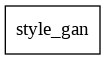

In [ ]:
keras.utils.plot_model(style_gan)

In [ ]:
def train(
    start_res=START_RES,
    target_res=TARGET_RES,
    steps_per_epoch=5000,
    display_images=True,
):
    opt_cfg = {"learning_rate": 1e-3, "beta_1": 0.0, "beta_2": 0.99, "epsilon": 1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))
    val_noise = style_gan.generate_noise(val_batch_size)

    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2 + 1):
        res = 2 ** res_log2
        for phase in ["TRANSITION", "STABLE"]:
            if res == start_res and phase == "TRANSITION":
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(
                d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                g_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                loss_weights={"gradient_penalty": 10, "drift": 0.001},
                steps_per_epoch=steps,
                res=res,
                phase=phase,
                run_eagerly=False,
            )

            prefix = f"res_{res}x{res}_{style_gan.phase}"

            ckpt_cb = keras.callbacks.ModelCheckpoint(
                f"checkpoints/stylegan_{res}x{res}.ckpt",
                save_weights_only=True,
                verbose=0,
            )
            print(phase)
            style_gan.fit(
                train_dl, epochs=1, steps_per_epoch=steps, callbacks=[ckpt_cb]
            )

            if display_images:
                images = style_gan({"z": val_z, "noise": val_noise, "alpha": 1.0})
                plot_images(images, res_log2)

In [ ]:
train(start_res=4, target_res=16, steps_per_epoch=1, display_images=False)


In [ ]:
url = "https://github.com/soon-yau/stylegan_keras/releases/download/keras_example_v1.0/stylegan_128x128.ckpt.zip"

weights_path = keras.utils.get_file(
    "stylegan_128x128.ckpt.zip",
    url,
    extract=True,
    cache_dir=os.path.abspath("."),
    cache_subdir="pretrained",
)

style_gan.grow_model(128)
style_gan.load_weights(os.path.join("pretrained/stylegan_128x128.ckpt"))

tf.random.set_seed(196)
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({"style_code": w, "noise": noise, "alpha": 1.0})
plot_images(images, 5)

In [ ]:
alpha = 0.4
w_mix = np.expand_dims(alpha * w[0] + (1 - alpha) * w[1], 0)
noise_a = [np.expand_dims(n[0], 0) for n in noise]
mix_images = style_gan({"style_code": w_mix, "noise": noise_a})
image_row = np.hstack([images[0], images[1], mix_images[0]])
plt.figure(figsize=(9, 3))
plt.imshow(image_row)
plt.axis("off")